# Optimising sowing date

* **Compatibility:** We use matplotlib.pyplot.subplots with cartopy projection for mapping. The attribute ".set_extent" doesn't work here so we use the attributes ".set_xlim" and ".set_ylim" instead.
* **Products used:** GRDC + CSIRO + UniSQ + UQ's calibrated wheat yield simulation database with frost and heat impacts ([An-Vo et al. 2018, Ecological Economics](https://www.sciencedirect.com/science/article/pii/S0921800916314203)). This dataset is stored in the file "fiFrostImpactYearly_n.csv". We also need information of the studied sites being stored in "station.csv" as well as the shape file for Australia state boundaries "STE_2021_AUST_GDA2020.shp" and "STE_2021_AUST_GDA2020.shx".  

## Background

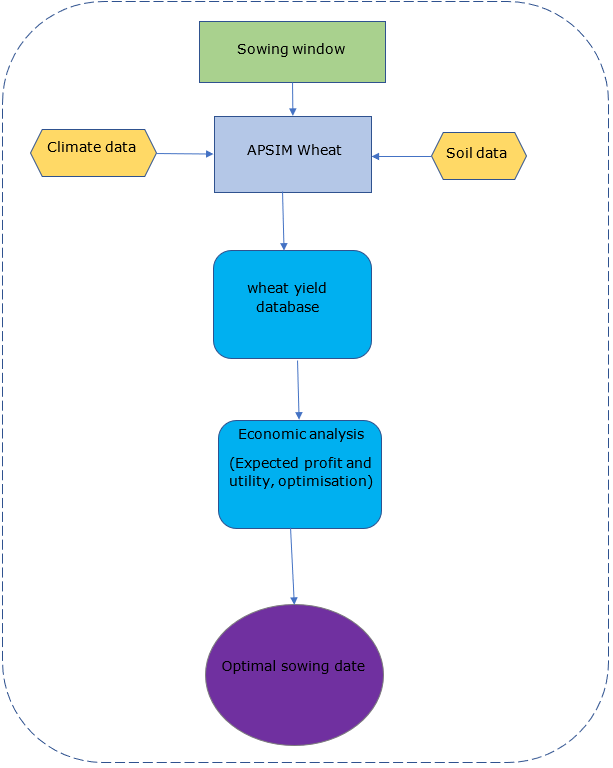

## Description

## Getting started

In [1]:
# Loading modules and packages
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
#import plotly.express as px
import pandas as pd
#import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import numpy as np
import netCDF4
from netCDF4 import num2date, date2num, date2index  # To deal with time variables
from scipy import signal
import math
import os
import requests
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify as mc

## Formulating the application

In [2]:
# Loading required data other than wheat yield data
stations = r'stations.csv'                                                # Data regarding information for studied sites
# Loading the data
dfS = pd.read_csv(stations, sep = r'\s*,\s*', engine = 'python')
dfS

,Sites,Weather Station,Zones,Wheat price ($/t),Regions,Input cost without N ($/ha),Zonal names,Latitude,Longitude
0,Goondiwindi,41038,2,238,1,216.4,NSW NE/QLD SE,-28.55,150.31
1,Meandarra,42022,2,238,1,216.4,NSW NE/QLD SE,-27.33,149.88
2,Dalby,41023,2,238,1,216.4,NSW NE/QLD SE,-27.18,151.26
3,Roma,43030,3,237,1,202.8,NSW NW/QLD SW,-26.57,148.79
4,Emerald,35027,1,246,1,284.6,QLD Central,-23.53,148.16
5,Condobolin,50052,5,234,1,207.8,NSW Central,-33.07,147.23
6,Wellington,65028,4,235,1,213.6,NSW Vic Slopes,-32.80,148.80
7,Dubbo,65012,2,238,1,216.4,NSW NE/QLD SE,-32.24,148.61
8,Gilgandra,51018,2,238,1,216.4,NSW NE/QLD SE,-31.71,148.66
9,Nyngan,51039,5,234,1,207.8,NSW Central,-31.55,147.20


In [3]:
# Using geopandas to convert long and lat to points
dfG = gpd.GeoDataFrame(dfS, geometry = gpd.points_from_xy(
dfS.Longitude, dfS.Latitude))
dfG

,Sites,Weather Station,Zones,Wheat price ($/t),Regions,Input cost without N ($/ha),Zonal names,Latitude,Longitude,geometry
0,Goondiwindi,41038,2,238,1,216.4,NSW NE/QLD SE,-28.55,150.31,POINT (150.31000 -28.55000)
1,Meandarra,42022,2,238,1,216.4,NSW NE/QLD SE,-27.33,149.88,POINT (149.88000 -27.33000)
2,Dalby,41023,2,238,1,216.4,NSW NE/QLD SE,-27.18,151.26,POINT (151.26000 -27.18000)
3,Roma,43030,3,237,1,202.8,NSW NW/QLD SW,-26.57,148.79,POINT (148.79000 -26.57000)
4,Emerald,35027,1,246,1,284.6,QLD Central,-23.53,148.16,POINT (148.16000 -23.53000)
5,Condobolin,50052,5,234,1,207.8,NSW Central,-33.07,147.23,POINT (147.23000 -33.07000)
6,Wellington,65028,4,235,1,213.6,NSW Vic Slopes,-32.80,148.80,POINT (148.80000 -32.80000)
7,Dubbo,65012,2,238,1,216.4,NSW NE/QLD SE,-32.24,148.61,POINT (148.61000 -32.24000)
8,Gilgandra,51018,2,238,1,216.4,NSW NE/QLD SE,-31.71,148.66,POINT (148.66000 -31.71000)
9,Nyngan,51039,5,234,1,207.8,NSW Central,-31.55,147.20,POINT (147.20000 -31.55000)


In [4]:
# Loading shapefile for Australia states
states_path = 'STE_2021_AUST_GDA2020.shp'                                 # Shapefile for Australia states
state_feature = ShapelyFeature(Reader(states_path).geometries(),          # Get the state features for later mapping
                               crs=ccrs.PlateCarree(), 
                               edgecolor = 'black')
shapefile = gpd.read_file(states_path)
shapefile

,geometry
0,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218..."
1,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072..."
3,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,"POLYGON ((149.06239 -35.15910, 149.09134 -35.1..."
8,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."
9,None


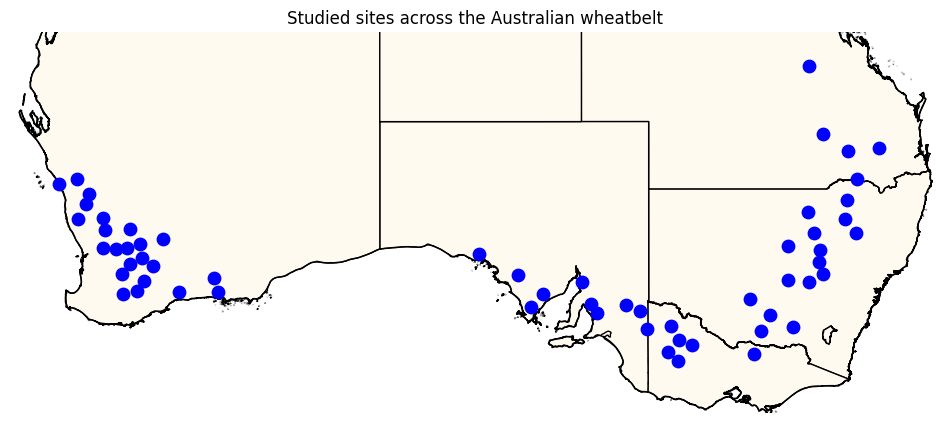

In [5]:
# Mapping the studied sites
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_xlim([112.5, 154])
ax.set_ylim([-39, -22])
ax.coastlines(color='black', linewidth=1, resolution='50m')
ax.set_title('Studied sites across the Australian wheatbelt')
ax.set_axis_off()
ax.add_feature(state_feature, 
                     facecolor="floralwhite", 
                     zorder=1)
dfG.plot(ax = ax, color = 'b', markersize=80, zorder=2)
fig.set_size_inches(12,8)

## Wheat yield database

In [6]:
# The Frosted Wheat Yield database is too large to include in the github repo.
# This code will pull down the data file from the AgReFed data cache.
# This is designed to run from the AgReFed container in the National Jupyterhub Service
# If running elsewhere the paths may need to be adjusted.

# Base URL to the Frosted Wheat Yield dataset
base_url_of_crop_modelling_data = 'https://data.agrefed.org.au/crop_modelling/'

# Filename of the Frosted Wheat Yield dataset
filename_of_crop_modelling_data = 'fiFrostImpactYearly_n.csv.gz'

# Path to local storage
local_path_to_crop_modelling_data = os.path.join(os.sep, 'home', 'jovyan', 'crop_modelling_data')

# Complete filename with path
local_filename_crop_modelling_data = os.path.join(local_path_to_crop_modelling_data, filename_of_crop_modelling_data)

# Create the local storage directory
if not os.path.exists(local_path_to_crop_modelling_data):
    os.mkdir(local_path_to_crop_modelling_data)

# Download and save data file
if not os.path.isfile(local_filename_crop_modelling_data):
    with requests.get(base_url_of_crop_modelling_data + filename_of_crop_modelling_data, stream=True) as r:
        r.raise_for_status()
        with open(local_filename_crop_modelling_data, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        
# Loading the frosted wheat yield database
dfY = pd.read_csv(local_filename_crop_modelling_data, compression='gzip', index_col='sites')
dfY

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
8025,1957,0,91,Medium,5,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,4,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,3,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,2,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,1,890.640002,20.0,30.0,6.0,81.0
...,...,...,...,...,...,...,...,...,...,...
89016,2013,140,181,Medium,3,2334.420000,50.0,120.0,0.0,125.0
89016,2013,140,181,Medium,2,2334.420000,50.0,120.0,0.0,125.0
89016,2013,140,181,Medium,1,2334.420000,50.0,120.0,0.0,125.0


## Working with wheat yield data at a site 

In [7]:
# Extract wheat yield data for a site (Carnamah)  
dfY_Carnamah = dfY.loc[dfS.loc[55, "Weather Station"], :]
dfY_Carnamah

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
8025,1957,0,91,Medium,5,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,4,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,3,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,2,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,91,Medium,1,890.640002,20.0,30.0,6.0,81.0
...,...,...,...,...,...,...,...,...,...,...
8025,2013,140,181,Medium,3,976.707200,20.0,100.0,60.0,97.0
8025,2013,140,181,Medium,2,976.707200,20.0,100.0,60.0,97.0
8025,2013,140,181,Medium,1,976.707200,20.0,100.0,60.0,97.0


In [8]:
# Extract wheat yield data for current genotype at the site
dfY0_Carnamah = dfY_Carnamah[dfY_Carnamah['post_head'] == '0']
dfY0_Carnamah

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
8025,1957,0,91,Medium,0,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,92,Medium,0,910.360004,20.0,30.0,6.0,82.0
8025,1957,0,93,Medium,0,943.219983,20.0,30.0,6.0,83.0
8025,1957,0,94,Medium,0,957.159985,20.0,30.0,6.0,83.0
8025,1957,0,95,Medium,0,989.960010,20.0,30.0,6.0,84.0
...,...,...,...,...,...,...,...,...,...,...
8025,2013,140,177,Medium,0,1035.630000,20.0,100.0,60.0,99.0
8025,2013,140,178,Medium,0,1018.830000,20.0,100.0,60.0,98.0
8025,2013,140,179,Medium,0,1005.939000,20.0,100.0,60.0,97.0


In [9]:
# Extract wheat yield data with no extra nitrogen added
dfY0_n0_Carnamah = dfY0_Carnamah[dfY0_Carnamah['nitrogen'] == 0]
dfY0_n0_Carnamah

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
8025,1957,0,91,Medium,0,890.640002,20.0,30.0,6.0,81.0
8025,1957,0,92,Medium,0,910.360004,20.0,30.0,6.0,82.0
8025,1957,0,93,Medium,0,943.219983,20.0,30.0,6.0,83.0
8025,1957,0,94,Medium,0,957.159985,20.0,30.0,6.0,83.0
8025,1957,0,95,Medium,0,989.960010,20.0,30.0,6.0,84.0
...,...,...,...,...,...,...,...,...,...,...
8025,2013,0,177,Medium,0,975.307200,20.0,30.0,18.0,99.0
8025,2013,0,178,Medium,0,963.827200,20.0,30.0,18.0,98.0
8025,2013,0,179,Medium,0,952.515200,20.0,30.0,18.0,97.0


In [10]:
# Wheat yield at one sowing date
dfY0_n0_Carnamah[dfY0_n0_Carnamah['sowing_date'] == 91]

,Year,nitrogen,sowing_date,cultivar,post_head,yield,nsowing,n30,n37,flow_das
sites,,,,,,,,,,
8025,1957,0,91,Medium,0,890.640002,20.0,30.0,6.0,81.0
8025,1958,0,91,Medium,0,1155.900000,20.0,30.0,6.0,82.0
8025,1959,0,91,Medium,0,976.220013,20.0,30.0,6.0,80.0
8025,1960,0,91,Medium,0,1954.820020,20.0,30.0,12.0,97.0
8025,1961,0,91,Medium,0,1776.460010,20.0,30.0,30.0,90.0
8025,1962,0,91,Medium,0,899.739984,20.0,30.0,6.0,78.0
8025,1963,0,91,Medium,0,1407.300000,20.0,30.0,12.0,86.0
8025,1964,0,91,Medium,0,998.960004,20.0,30.0,6.0,90.0
8025,1965,0,91,Medium,0,1705.539990,20.0,30.0,12.0,86.0


## Optimal planting date

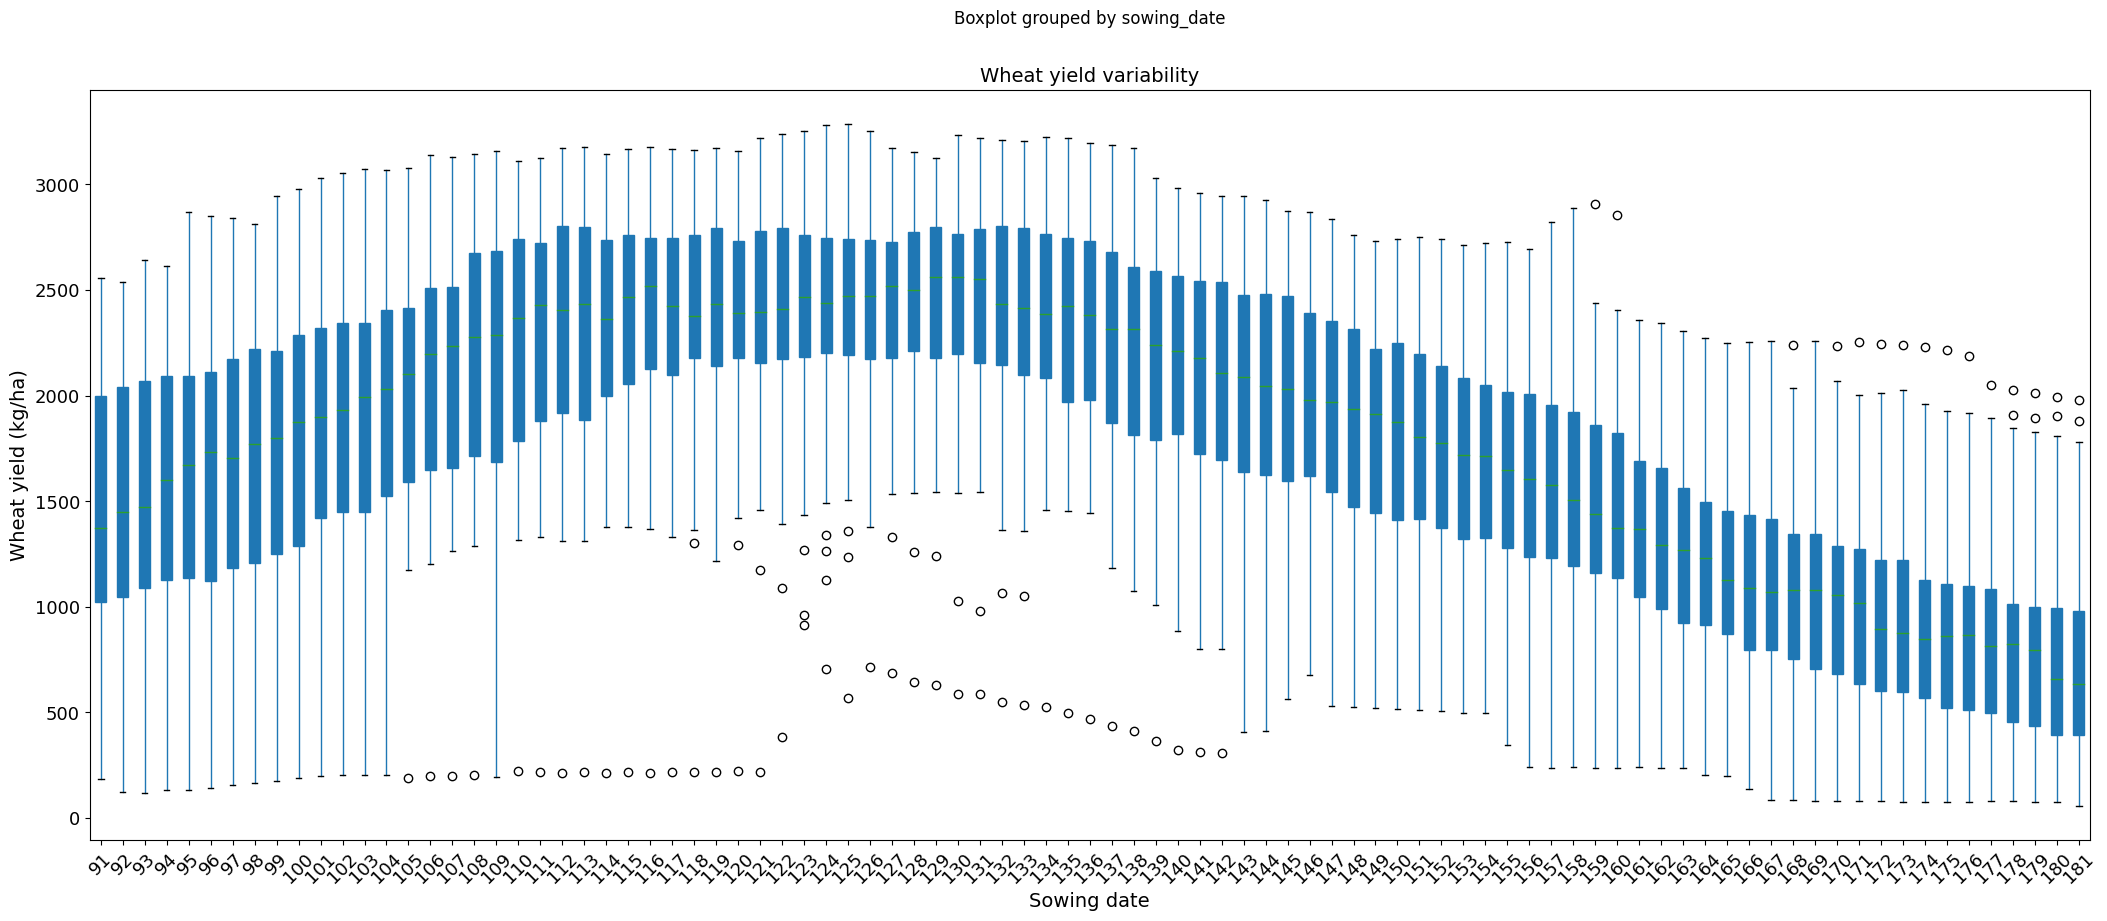

In [11]:
fig, ax = plt.subplots(1,1)
dfY0_n0_Carnamah.boxplot(ax = ax, column='yield', by='sowing_date', rot=45, fontsize = 13, patch_artist = True, grid = False) 
ax.set_title('Wheat yield variability', fontsize=14)
ax.set_xlabel('Sowing date', fontsize=14)
ax.set_ylabel('Wheat yield (kg/ha)', fontsize=14)
fig.set_size_inches(25, 10)

In [12]:
# Create a series of sowing days
sd = pd.date_range('2011-04-01', periods= 91, freq='D')
sd = pd.Series(sd, index = np.arange(91,182,1))
sd = sd.dt.strftime('%m-%d')                     # Keeping just days and months

# Estimating average wheat yields for each sowing date at all sites
dfYe_sites = pd.DataFrame({})
dfYe_sites["SowingDate"] = sd
# Iterate over the sites
OptSow = []                                                       # Optimal sowing dates for all sites
MaxY = []                                                         # Maximum yield at each site
for index, row in dfS.iterrows():
    dfY_site = dfY.loc[dfS.loc[index, "Weather Station"], :]      # Extract wheat yield dataframe at a site
    dfY0_site = dfY_site[dfY_site["post_head"] == '0']            # For current genotype
    dfY0_n0_site = dfY0_site[dfY0_site["nitrogen"] == 0]          # No added nitrogen
    mYs = []
    for i in np.arange(91,182,1):
        mY = dfY0_n0_site[dfY0_n0_site['sowing_date'] == i]['yield'].mean()/1000
        mYs.append(mY)
    # Convert a list object to a pandas series
    mYs = pd.Series(mYs, index = np.arange(91,182,1))
    OptSow.append(sd[mYs.idxmax()])
    MaxY.append(mYs.max())
    dfYe_sites[dfS.Sites[index]] = mYs
dfYe_sites

,SowingDate,Goondiwindi,Meandarra,Dalby,Roma,Emerald,Condobolin,Wellington,Dubbo,Gilgandra,...,Merredin,SouthernCross,WonganHills,Bencubbin,Badgingarra,Dalwallinu,Carnamah,Morawa,Geraldton,Mullewa
91,04-01,0.781574,0.139819,0.236585,0.097399,1.449639,0.007814,0.000801,0.106331,0.012210,...,0.345834,0.097299,1.980645,0.973184,1.747213,1.502485,1.481471,1.170758,1.331950,0.576390
92,04-02,0.790112,0.143724,0.236633,0.090102,1.467317,0.012111,0.001193,0.108191,0.012284,...,0.345194,0.097077,2.009645,0.976230,1.780550,1.536422,1.519043,1.192012,1.362637,0.584876
93,04-03,0.805750,0.141026,0.235309,0.086745,1.466935,0.017194,0.001801,0.110228,0.012361,...,0.351386,0.097524,2.048099,0.996994,1.811430,1.564130,1.540736,1.216580,1.392409,0.590385
94,04-04,0.812414,0.146828,0.237636,0.082539,1.464448,0.021645,0.002808,0.114031,0.011324,...,0.355852,0.098562,2.078105,1.029064,1.838108,1.607374,1.599104,1.256443,1.430123,0.598909
95,04-05,0.829868,0.150068,0.239008,0.080360,1.464965,0.027077,0.005085,0.112700,0.015957,...,0.365688,0.100565,2.116492,1.050395,1.869694,1.661131,1.638871,1.279328,1.463173,0.608132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,06-26,1.622406,1.378036,2.089908,0.668714,0.688484,1.516358,2.486562,2.341073,2.020558,...,0.756888,0.335109,1.171571,0.691766,1.190114,0.880206,0.837839,0.588966,1.377356,0.235313
178,06-27,1.616666,1.369650,2.089416,0.671850,0.671149,1.491805,2.452645,2.310575,1.994646,...,0.742524,0.329125,1.150278,0.666484,1.159159,0.867048,0.806365,0.572482,1.382594,0.230540
179,06-28,1.626620,1.371076,2.101855,0.672911,0.649028,1.483292,2.449876,2.301183,1.987058,...,0.716430,0.323531,1.126838,0.645728,1.124310,0.834441,0.787796,0.551791,1.354393,0.224493
180,06-29,1.609722,1.358497,2.095061,0.684974,0.629700,1.466010,2.410200,2.295914,1.963119,...,0.706965,0.321987,1.092026,0.634637,1.116202,0.807585,0.761325,0.541294,1.290594,0.217253


The optimal sowing date at Emerald is: 05-12

The optimal sowing date at Dookie is: 06-03

The optimal sowing date at Roseworthy is: 05-31

The optimal sowing date at Carnamah is: 05-09



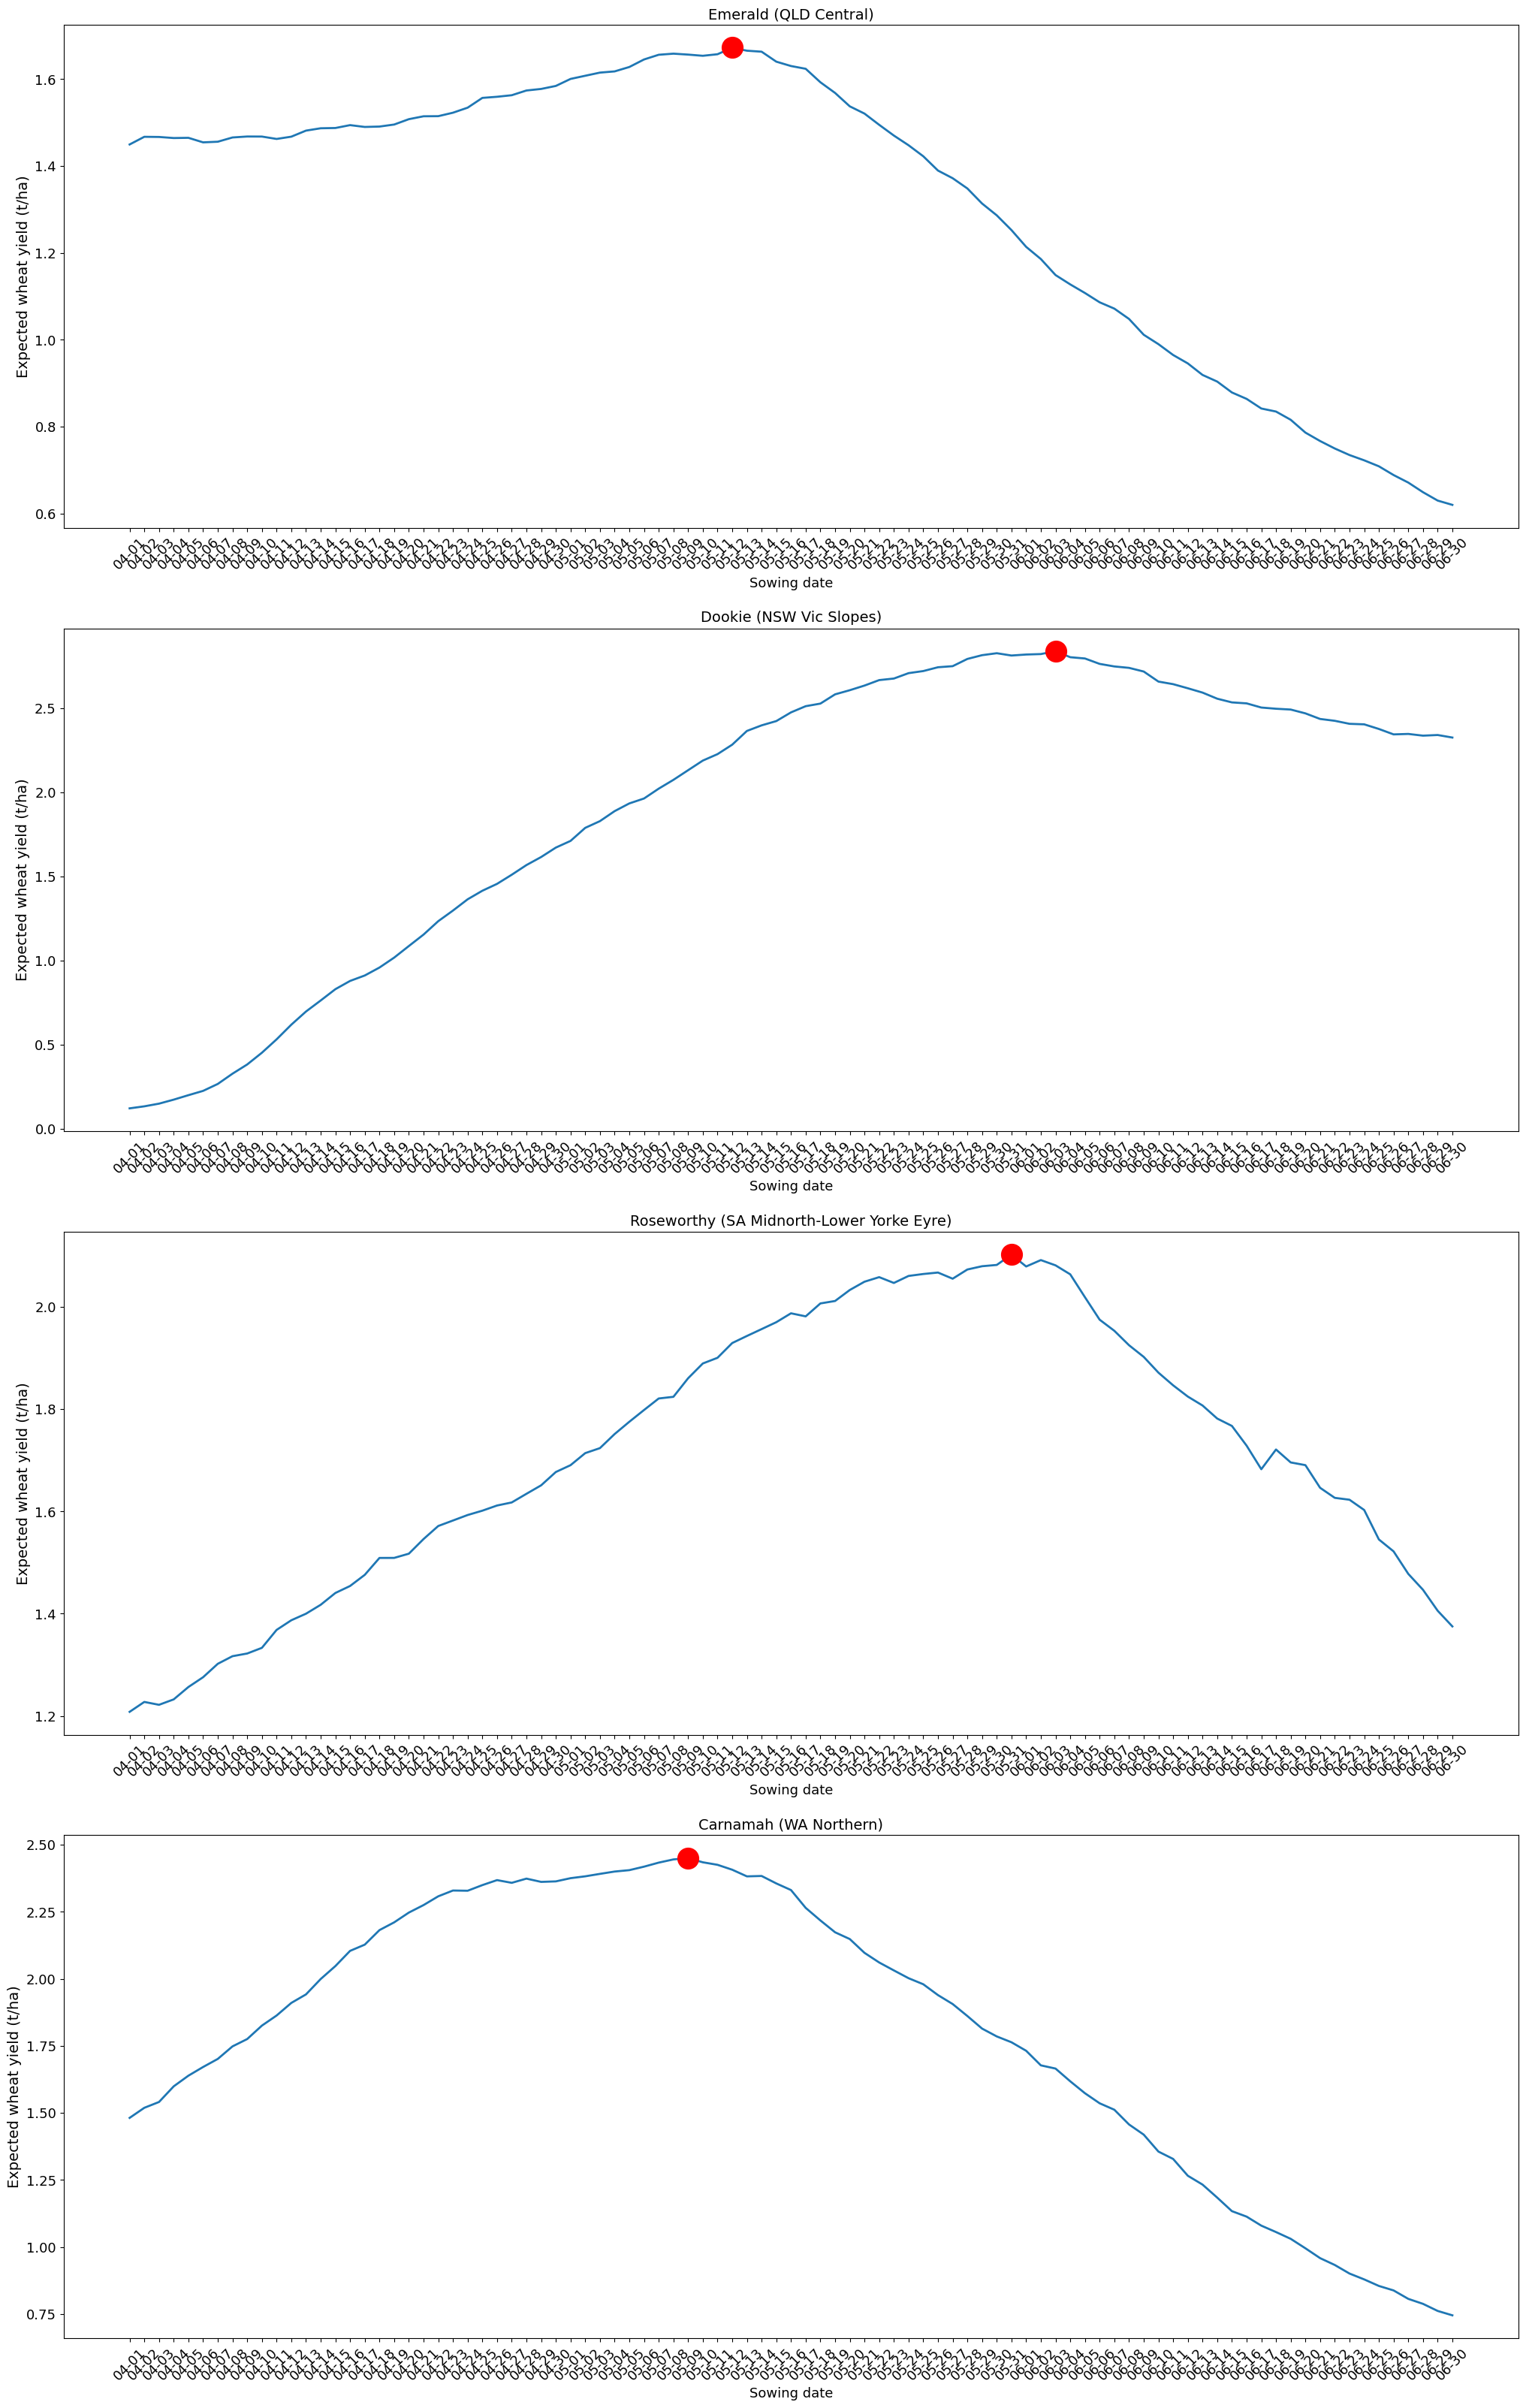

In [13]:
# Plotting the optimal sowing day
fig, axs = plt.subplots(4, 1)
fig.set_size_inches(25, 40)

# At Emerald (QLD Central)
axs[0].plot(sd, dfYe_sites["Emerald"], linewidth=2)
axs[0].plot(sd[dfYe_sites["Emerald"].idxmax()], dfYe_sites["Emerald"].max(), 'o', c = 'r', markersize=20)     # Marking the optimal sowing date, 
axs[0].tick_params(axis = 'x', labelrotation = 45, labelsize = 13)
axs[0].tick_params(axis = 'y', labelsize = 13)
axs[0].set_ylabel('Expected wheat yield (t/ha)', fontsize=14)
axs[0].set_xlabel('Sowing date', fontsize=13)
axs[0].set_title("Emerald (QLD Central)", fontsize=14)
print('The optimal sowing date at Emerald is:', sd[dfYe_sites["Emerald"].idxmax()])
print()

# At Dookie (NSW Vic Slopes)
axs[1].plot(sd, dfYe_sites["Dookie"], linewidth=2)
axs[1].plot(sd[dfYe_sites["Dookie"].idxmax()], dfYe_sites["Dookie"].max(), 'o', c = 'r', markersize=20)     # Marking the optimal sowing date, 
axs[1].tick_params(axis = 'x', labelrotation = 45, labelsize = 13)
axs[1].tick_params(axis = 'y', labelsize = 13)
axs[1].set_ylabel('Expected wheat yield (t/ha)', fontsize=14)
axs[1].set_xlabel('Sowing date', fontsize=13)
axs[1].set_title("Dookie (NSW Vic Slopes)", fontsize=14)
print('The optimal sowing date at Dookie is:', sd[dfYe_sites["Dookie"].idxmax()])
print()

# At Roseworthy (SA Midnorth-Lower Yorke Eyre)
axs[2].plot(sd, dfYe_sites["Roseworthy"], linewidth=2)
axs[2].plot(sd[dfYe_sites["Roseworthy"].idxmax()], dfYe_sites["Roseworthy"].max(), 'o', c = 'r', markersize=20)     # Marking the optimal sowing date, 
axs[2].tick_params(axis = 'x', labelrotation = 45, labelsize = 13)
axs[2].tick_params(axis = 'y', labelsize = 13)
axs[2].set_ylabel('Expected wheat yield (t/ha)', fontsize=14)
axs[2].set_xlabel('Sowing date', fontsize=13)
axs[2].set_title("Roseworthy (SA Midnorth-Lower Yorke Eyre)", fontsize=14)
print('The optimal sowing date at Roseworthy is:', sd[dfYe_sites["Roseworthy"].idxmax()])
print()

# At Carnamah (WA Northern)
axs[3].plot(sd, dfYe_sites["Carnamah"], linewidth=2)
axs[3].plot(sd[dfYe_sites["Carnamah"].idxmax()], dfYe_sites["Carnamah"].max(), 'o', c = 'r', markersize=20)     # Marking the optimal sowing date, 
axs[3].tick_params(axis = 'x', labelrotation = 45, labelsize = 13)
axs[3].tick_params(axis = 'y', labelsize = 13)
axs[3].set_ylabel('Expected wheat yield (t/ha)', fontsize=14)
axs[3].set_xlabel('Sowing date', fontsize=13)
axs[3].set_title("Carnamah (WA Northern)", fontsize=14)
#axs[0].set_xlim(sd[91], sd[181])
print('The optimal sowing date at Carnamah is:', sd[dfYe_sites["Carnamah"].idxmax()])
print()

## Interactive map of optimal sowing dates

In [14]:
# Add the optimal sowing date and maximum yield at each site to the GeoDataframe
OptSow = pd.Series(OptSow)
MaxY = pd.Series(MaxY)
dfG["OptimalSow"] = OptSow
dfG["MaxYield"] = MaxY
dfG

,Sites,Weather Station,Zones,Wheat price ($/t),Regions,Input cost without N ($/ha),Zonal names,Latitude,Longitude,geometry,OptimalSow,MaxYield
0,Goondiwindi,41038,2,238,1,216.4,NSW NE/QLD SE,-28.55,150.31,POINT (150.31000 -28.55000),05-16,2.241304
1,Meandarra,42022,2,238,1,216.4,NSW NE/QLD SE,-27.33,149.88,POINT (149.88000 -27.33000),05-26,1.615003
2,Dalby,41023,2,238,1,216.4,NSW NE/QLD SE,-27.18,151.26,POINT (151.26000 -27.18000),06-03,2.204867
3,Roma,43030,3,237,1,202.8,NSW NW/QLD SW,-26.57,148.79,POINT (148.79000 -26.57000),05-30,0.896889
4,Emerald,35027,1,246,1,284.6,QLD Central,-23.53,148.16,POINT (148.16000 -23.53000),05-12,1.672495
5,Condobolin,50052,5,234,1,207.8,NSW Central,-33.07,147.23,POINT (147.23000 -33.07000),06-18,1.545570
6,Wellington,65028,4,235,1,213.6,NSW Vic Slopes,-32.80,148.80,POINT (148.80000 -32.80000),06-03,2.642641
7,Dubbo,65012,2,238,1,216.4,NSW NE/QLD SE,-32.24,148.61,POINT (148.61000 -32.24000),06-02,2.609357
8,Gilgandra,51018,2,238,1,216.4,NSW NE/QLD SE,-31.71,148.66,POINT (148.66000 -31.71000),05-26,2.365353
9,Nyngan,51039,5,234,1,207.8,NSW Central,-31.55,147.20,POINT (147.20000 -31.55000),05-18,2.104285


In [15]:
import folium
# Create a map pin point to Australia
my_map = folium.Map(
    location = [-30.98, 135.92],
    zoom_start = 4.5
)
# Create interactive markers for all studied sites
for _, site in dfG.iterrows():
    folium.Marker(
        location=[site['Latitude'], site['Longitude']],
        popup=site['MaxYield'],
        tooltip=site['OptimalSow']
    ).add_to(my_map)

my_map

In [16]:
# Saving the map in html file to put in the web
my_map.save('planting_map.html')